In [1]:
from matplotlib import image
from matplotlib import pyplot
import matplotlib.pyplot as plt

import numpy as np
import os


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.optim import Optimizer

import scipy
from scipy import stats
import copy

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #channel2 = 16

        #channel1 = 16
        channel1 = 32
        channel2 = 16
        maxPool2 = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=channel1,
                kernel_size=7,
                stride=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel1, channel2, 7, 1),
            nn.ReLU(),
            nn.MaxPool2d(maxPool2),
        )
        # fully connected layer, output 10 classes
        #self.out = nn.Linear(32 * 7 * 7, 10)
        #self.out = nn.Linear(channel2 * 8 * 8, 1)
        #self.out = nn.Linear(channel2 * 7 * 7, 1)
        self.out = nn.Linear(channel2 * 5 * 5, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [3]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        #channel2 = 16

        channel1 = 16
        channel2 = 16
        maxPool2 = 2

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=channel1,
                kernel_size=7,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel1, channel2, 7, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(maxPool2),
        )
        # fully connected layer, output 10 classes
        #self.out = nn.Linear(32 * 7 * 7, 10)
        self.out = nn.Linear(channel2 * 8 * 8, 1)
        #self.out = nn.Linear(channel2 * 5 * 5, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [4]:
def loadnpz(name, allow_pickle=False):
    if allow_pickle:
        data = np.load(name, allow_pickle=True)
    else:
        data = np.load(name)
    data = data.f.arr_0
    return data

def doDownSample(image, downSize):

    size1 = image.shape[0] // downSize
    image = image[:(size1*downSize), :(size1*downSize)]

    image = image.reshape((image.shape[0] // downSize, downSize, image.shape[1] // downSize, downSize, 3))
    image = np.sum(image, axis=(1, 3))
    image = image // (downSize **  2)

    return image


def downSampler():

    folder1 = './Age/crop_part1/'
    fNames = os.listdir(folder1)

    downSize = 5

    allImages = np.zeros((len(fNames), 200 // downSize, 200 // downSize, 3), dtype=int)
    ageList = np.zeros(len(fNames), dtype=int)

    for a in range(len(fNames)):

        print (a)
        fname = fNames[a]

        age1 = int(fname.split('_')[0])

        ageList[a] = age1


        image2 = image.imread(folder1 + fname)


        image2 = doDownSample(image2, downSize)

        allImages[a] = np.copy(image2)

    np.savez_compressed('./Age/data/allImages.npz', allImages)
    np.savez_compressed('./Age/data/allAges.npz', ageList)

In [5]:
# downSampler()

In [6]:
def original_trainModel():


    X = loadnpz('./Age/data/allImages.npz')
    Y = loadnpz('./Age/data/allAges.npz')

    Y = Y / 100
    X = np.swapaxes(X, 1, 3)
    X = np.swapaxes(X, 2, 3)


    N = Y.shape[0]
    perm1 = np.random.permutation(N)
    X = X[perm1]
    Y = Y[perm1]
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()

    N_test = 1000
    X_test = X[:N_test]
    Y_test = Y[:N_test]
    X = X[N_test:]
    Y = Y[N_test:]

    N_train = Y.shape[0]

    #print (X.shape)
    #quit()



    model = CNN()

    #learningRate = 1e-3
    learningRate = 5e-4
    #learningRate = 2e-4
    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)


    iterN = 100
    batchSize = 100
    Nbatch = N_train // batchSize

    for iter in range(iterN):

        for batchNum in range(Nbatch):

            #if (batchNum % 100 == 0):
            #    print ('batchnum: ', batchNum, Nbatch)

            X_batch = X[batchNum*batchSize:(batchNum+1)*batchSize]
            Y_batch = Y[batchNum*batchSize:(batchNum+1)*batchSize]

            pred, _ = model(X_batch)
            pred = pred[:, 0]

            loss = torch.mean((pred - Y_batch) ** 2)

            #print (loss)
            #cor1 = scipy.stats.pearsonr(pred.data.numpy(), Y_batch.data.numpy())

            #print (cor1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        pred_test, _ = model(X_test)
        pred_test = pred_test[:, 0]

        cor_test = scipy.stats.pearsonr(pred_test.data.numpy(), Y_test.data.numpy())

        pred_train, _ = model(X[:N_test])
        pred_train = pred_train[:, 0]

        cor_train = scipy.stats.pearsonr(pred_train.data.numpy(), Y[:N_test].data.numpy())

        #print ("Scores")
        print ('iter', iter)
        print (cor_train)
        print (cor_test)

In [7]:
def calculateGradVector(model, sizeTotal):

    count1 = 0
    gradNow = torch.zeros((sizeTotal,))
    for param in model.parameters():
        size1 = param.nelement()
        grad1 = param.grad
        #print (grad1)
        grad1 = torch.clone(grad1.data)
        grad1 = grad1.reshape((size1,))

        gradNow[count1:count1+size1] = torch.clone(grad1)
        count1 += size1

    return gradNow

def findParamVec(model, sizeTotal):

    count1 = 0
    paramVec = torch.zeros((sizeTotal,)).to('cuda')

    for param in model.parameters():
        size1 = param.nelement()
        param1 = torch.clone(param.data)
        param1 = param1.reshape((size1,))

        #print (param1)

        paramVec[count1:count1+size1] = torch.copy(param1)
        count1 += size1
    #print (paramVec)
    #quit()
    return paramVec



def findDataGrad(X, Y, model, optimizer, sizeTotal):

    dataGrad = torch.zeros((X.shape[0],  sizeTotal)).to('cuda')

    for a in range(X.shape[0]):
        pred1, _ = model(X[a:a+1])

        loss1 = (pred1[0, 0] - Y[a]) ** 2
        loss1.backward()

        gradNow = calculateGradVector(model, sizeTotal)
        dataGrad[a] = torch.clone(gradNow)

        optimizer.zero_grad()

    return dataGrad

In [12]:
from importlib.metadata import requires


def trainModel(useMeta = False, metaTest = True, restrictTrain = False, saveFile = None, saveModel = False, iterN = 100, model_name = None, trainFromLast = False):

    # useMeta = False


    X = loadnpz('./Age/data/allImages.npz')
    Y = loadnpz('./Age/data/allAges.npz')

    #print (X.shape)
    #quit()

    #plt.hist(Y, bins=100)
    #plt.show()
    #quit()

    Y = Y / 100
    X = np.swapaxes(X, 1, 3)
    X = np.swapaxes(X, 2, 3)

    minAge_test = 0.14
    maxAge_test = 0.21

    #minAge_valid = 0.12
    #maxAge_valid = 0.23
    minAge_valid = 0.14
    maxAge_valid = 0.21





    N = Y.shape[0]
    rng = np.random.RandomState(0)
    perm1 = rng.permutation(N)
    X = X[perm1]
    Y = Y[perm1]

    N_test = 1000
    X_test = X[:N_test]
    Y_test = Y[:N_test]
    X = X[N_test:]
    Y = Y[N_test:]
    if useMeta:
        N_valid = 1000
        X_valid = X[:N_valid]
        Y_valid = Y[:N_valid]
        X = X[N_valid:]
        Y = Y[N_valid:]


        validArg = np.argwhere(np.logical_and(Y_valid >= minAge_valid, Y_valid <= maxAge_valid))[:, 0]
        X_valid = X_valid[validArg]
        Y_valid = Y_valid[validArg]

        X_valid = torch.tensor(X_valid).float().to('cuda')
        Y_valid = torch.tensor(Y_valid).float().to('cuda')


    X = torch.tensor(X).float().to('cuda')
    Y = torch.tensor(Y).float().to('cuda')
    X_test = torch.tensor(X_test).float().to('cuda')
    Y_test = torch.tensor(Y_test).float().to('cuda')




    # metaTest = True

    if metaTest:
        testArg = torch.argwhere(torch.logical_and(Y_test.data >= minAge_test, Y_test.data <= maxAge_test))[:, 0]
        X_test = X_test[testArg]
        Y_test = Y_test[testArg]


    # print(X)
    # restrictTrain = True
    if restrictTrain:
        trainArg = torch.argwhere(torch.logical_and(Y.data >= minAge_test, Y.data <= maxAge_test))[:, 0]
        X = X[trainArg]
        Y = Y[trainArg]
        # X = X.flatten(ax)
    #print (X.shape)
    #quit()


    N_train = Y.shape[0]

    # model = CNN()
    if(trainFromLast):
        model = torch.load('./models/'+model_name)
    else:
        model = torch.load('./models/2.pt')
    model.to('cuda')

    sizeTotal = 0
    for param in model.parameters():
        size1 = param.nelement()
        sizeTotal += size1



    #learningRate = 1e-3
    #learningRate = 5e-4
    learningRate = 3e-4
    #learningRate = 2e-4
    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)


    
    batchSize = 10000
    Nbatch = (N_train+batchSize-1) // batchSize

    trainLoss = []
    if trainFromLast:
        trainLoss = np.load(saveFile)
    gamma = 0.2
    old_loss_Valid = None
    best_val_loss = 0


    with torch.no_grad():
        pred_test, _ = model(X_test)
        pred_test = pred_test[:, 0]

        cor_test = scipy.stats.pearsonr(pred_test.data.cpu().numpy(), Y_test.data.cpu().numpy())

        if useMeta:
            pred_valid, _ = model(X_valid)
            pred_valid = pred_valid[:, 0]

            #print (pred_valid.shape, Y_valid.shape)
            cor_valid = scipy.stats.pearsonr(pred_valid.data.cpu().numpy(), Y_valid.data.cpu().numpy())

        pred_train, _ = model(X[:N_test])
        pred_train = pred_train[:, 0]

        cor_train = scipy.stats.pearsonr(pred_train.data.cpu().numpy(), Y[:N_test].data.cpu().numpy())

        lossInfo = [cor_train[0], cor_test[0]]

        #print ("Scores")
        print ('iter', -1)
        print (cor_train)
        if useMeta:
            print (cor_valid)
            lossInfo = [cor_train[0], cor_valid[0], cor_test[0]]
        print (cor_test)

        trainLoss.append(copy.copy(lossInfo))



    for iter in range(iterN):
        for batchNum in range(Nbatch):
            if Y.shape[0] < (batchNum+1)*batchSize:
                X_batch = X[batchNum*batchSize:]
                Y_batch = Y[batchNum*batchSize:]
            else:
                X_batch = X[batchNum*batchSize:(batchNum+1)*batchSize]
                Y_batch = Y[batchNum*batchSize:(batchNum+1)*batchSize]

            if useMeta:
                dataGrad = findDataGrad(X_batch, Y_batch, model, optimizer, sizeTotal).to('cuda')

                pred_valid, _ = model(X_valid)
                pred_valid = pred_valid[:, 0]
                loss_Valid = torch.mean((pred_valid - Y_valid) ** 2)
                if old_loss_Valid is not None:
                    loss_Valid = gamma * loss_Valid + (1-gamma) * old_loss_Valid
                old_loss_Valid = torch.clone(loss_Valid).detach()
                loss_Valid.backward()

                validGrad = calculateGradVector(model, sizeTotal).to('cuda')
                validDir = validGrad.detach()
                validDir = validDir.reshape((1, validDir.shape[0]))

                dataValue = torch.mean(validDir * dataGrad, axis=1)

                # norm1 = torch.sum(validDir**2, axis=1) ** 0.5
                # norm2 = torch.sum(dataGrad**2, axis=1) ** 0.5
                # dataValue = dataValue / (5*norm1 * norm2)

                # plt.scatter(Y_batch.cpu().data.numpy(), dataValue.cpu())
                # plt.show()
                # quit()

                #weighting = np.zeros(dataValue.shape[0])
                #weighting[dataValue > 0] = 1

                weighting = torch.clone(dataValue)
                # weighting*=np.sqrt(batchSize)
                weighting[weighting<0] = 0
                weighting[weighting>1] = 1
                if(iter > 3):
                    gamma*=2
                    weighting = weighting/2
                if(iter > 6):
                    gamma*=2
                    weighting = weighting/2
                if(iter > 12):
                    weighting = weighting/4
                if(iter > 25):
                    weighting = weighting/4
                if(iter > 50):
                    weighting = weighting/4
                weighting = torch.sqrt(weighting).float()
                # weighting = weighting.float()

                #print (torch.mean(Y_batch[dataValue > 0]), torch.mean(Y_batch))



            pred, _ = model(X_batch)
            pred = pred[:, 0]
            loss = (pred - Y_batch) ** 2
            if useMeta:
                loss = loss * weighting

            loss = torch.mean(loss)
            # print(loss.requires_grad_)
            # loss.requires_grad_(True)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #print ('range')
        #print (np.quantile(Y_batch[dataValue > 0].data.numpy(), np.array([0.25, 0.75])))
        #print (np.quantile(Y_batch.data.numpy(), np.array([0.25, 0.75])))

        with torch.no_grad():
            pred_test, _ = model(X_test)
            pred_test = pred_test[:, 0]

            cor_test = scipy.stats.pearsonr(pred_test.data.cpu().numpy(), Y_test.data.cpu().numpy())

            if useMeta:
                pred_valid, _ = model(X_valid)
                pred_valid = pred_valid[:, 0]

                #print (pred_valid.shape, Y_valid.shape)
                cor_valid = scipy.stats.pearsonr(pred_valid.data.cpu().numpy(), Y_valid.data.cpu().numpy())

            pred_train, _ = model(X[:N_test])
            pred_train = pred_train[:, 0]

            cor_train = scipy.stats.pearsonr(pred_train.data.cpu().numpy(), Y[:N_test].data.cpu().numpy())

            lossInfo = [cor_train[0], cor_test[0]]

            #print ("Scores")
            print ('iter', iter)
            print (cor_train)
            if useMeta:
                print (cor_valid)
                lossInfo = [cor_train[0], cor_valid[0], cor_test[0]]
            print (cor_test)

            trainLoss.append(copy.copy(lossInfo))

        if saveFile:
            np.save(saveFile, np.array(trainLoss))
        if(saveModel):
            if(useMeta):
                if(cor_valid[0] > best_val_loss):
                    torch.save(model, './models/'+model_name)
                    best_val_loss = cor_valid[0]
            else:
                torch.save(model, './models/'+model_name)

In [9]:
# trainModel(useMeta=False, metaTest=False, restrictTrain=False, saveFile=None, saveModel = True)

In [14]:
iterN = 70
trainModel(iterN = iterN, useMeta=True, metaTest=True, restrictTrain=False, saveFile='./results/trainLoss_ours.npy', saveModel = True, model_name = 'ours.pt', trainFromLast = False)
trainModel(iterN = iterN,useMeta=False, metaTest=True, restrictTrain=True, saveFile='./results/trainLoss_someData.npy', saveModel = True, model_name = 'some.pt', trainFromLast = False)
trainModel(iterN = iterN,useMeta=False, metaTest=True, restrictTrain=False, saveFile='./results/trainLoss_allData.npy', saveModel = True, model_name = 'all.pt', trainFromLast = False)

iter -1
(0.2116933187958044, 2.547736094775565e-11)
(0.17789195152938658, 0.07660957518132656)
iter 0
(0.2641083479925208, 5.4336187038494043e-17)
(0.19043069349766145, 0.05772634060134387)
iter 1
(0.2550240767008751, 6.547443689630441e-16)
(0.24432255012659598, 0.014295313285356458)
iter 2
(0.26818778917020886, 1.7212825461930384e-17)
(0.2612257883747764, 0.008660725530342712)
iter 3
(0.2782850983246986, 9.180363159959572e-19)
(0.26780712471706764, 0.007064377071028387)
iter 4
(0.27344229766620215, 3.802505762978937e-18)
(0.25969074910957934, 0.009075838124719304)
iter 5
(0.2616542977113212, 1.074671429770746e-16)
(0.24218948894812475, 0.015194703163022901)
iter 6
(0.2510179271810775, 1.902976656333095e-15)
(0.22726351856270993, 0.02297178113430268)
iter 7
(0.24890000808876853, 3.3198896498372517e-15)
(0.22387902857523473, 0.02514640643709898)
iter 8
(0.2526568960192922, 1.2326715762245187e-15)
(0.22737627468569513, 0.022902191324439665)
iter 9
(0.254011678064388, 8.588862089446802e-1

: 

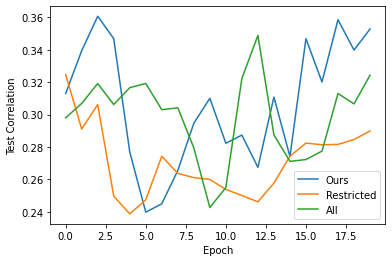

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plotTest():
    folder = 'results'
    loss_ours = np.load('./'+folder+'/trainLoss_ours.npy')
    loss_some = np.load('./'+folder+'/trainLoss_someData.npy')
    loss_all = np.load('./'+folder+'/trainLoss_allData.npy')


    plt.plot(loss_ours[:, -1])
    # plt.plot(loss_ours[:100, -2])
    # plt.plot(loss_ours[:, -2] - loss_ours[:, -1])
    plt.plot(loss_some[:, -1])
    plt.plot(loss_all[:, -1])
    plt.plot(loss_ours[:, -2])
    plt.plot(loss_some[:100, -2])
    # plt.legend(['Ours', 'Ours[Validation]','Restricted', 'Restricted[Test]', 'All Data'])
    plt.legend(['Ours', 'Restricted', 'All', 'Validation', 'Restricted Test'])
    # plt.legend(['Ours[Test]', 'Ours[Validation]', 'Difference'])
    plt.xlabel("Epoch")
    plt.ylabel("Test Correlation")
    plt.show()

plotTest()